In [1]:
import os

os.chdir('/home/jwdase/projects/language-detection/src')

DEVICE = 'cuda'

In [16]:
import glob 

base = "/om2/user/moshepol/prosody/models/test/prosody_epoch_20_tr"
name = 'prosody_TRANSFORM_tr_uz_epoch=13'

inputs = glob.glob(f'{base}/inputs*.pt')
lengths = glob.glob(f'{base}/lengths*.pt')
labels = glob.glob(f'{base}/outputs*.pt')

In [17]:
print(f'Total Inputs: {len(inputs)}')
print(f'Total Lengths: {len(lengths)}')
print(f'Total Outputs: {len(labels)}')

Total Inputs: 0
Total Lengths: 0
Total Outputs: 0


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

from language_detection.model.dataset import AudioDataset

dataset = AudioDataset()


for i, (inp, leng, out) in enumerate(zip(inputs, lengths, labels)):
    if i % 5 == 0:
        print(inp.split('/')[-1])
        print(leng.split('/')[-1])
        print(out.split('/')[-1])


    inputs = torch.load(inp, weights_only=False)
    lengths = torch.load(leng, weights_only=False)
    labels = torch.load(out, weights_only=False)

    for inp, leng, lab in zip(inputs, lengths, labels):
        dataset.additem(inp, leng, lab)

inputs_0.pt
lengths_0.pt
outputs_0.pt
inputs_13.pt
lengths_13.pt
outputs_13.pt
inputs_18.pt
lengths_18.pt
outputs_18.pt
inputs_22.pt
lengths_22.pt
outputs_22.pt
inputs_6.pt
lengths_6.pt
outputs_6.pt


In [5]:
loader = DataLoader(dataset, batch_size=64, num_workers=4, shuffle=False)

In [6]:
print(f'Shape is: {dataset.get_shape()}')
print(f'Files: {len(dataset)}')

Shape is: torch.Size([20, 297])
Files: 6144


In [7]:
import joblib

encoder = joblib.load(f'{base}/label_encoder.pkl')

class_to_index = {label : idx for idx, label in enumerate(encoder.classes_)}

print(class_to_index)

{np.str_('en'): 0, np.str_('de'): 1, np.str_('nl'): 2, np.str_('es'): 3, np.str_('it'): 4, np.str_('ja'): 5, np.str_('ta'): 6, np.str_('tr'): 7}


In [8]:
from language_detection.model.network import VarCNNTransformerLanguageDetector

num_classes = len(class_to_index)

model = VarCNNTransformerLanguageDetector(num_classes, dataset.get_shape())

model.load_state_dict(torch.load(f'{base}/best_model.pth', weights_only=True))
model.eval()

model.to(DEVICE)

VarCNNTransformerLanguageDetector(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (pos_encoder): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=640, out_features=640, bias=True)
        )
        (linear1): Linear(in_features=640, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=640, bias=True)
        (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (norm2):

In [9]:
import torch.nn.functional as F


y_pred = []
y_true = []
y_probs = []

with torch.no_grad():
    for inputs, length, label in loader:

        inputs = inputs.to(DEVICE)
        length = length.to(DEVICE)
        label = label.to(DEVICE)

        inputs = inputs.unsqueeze(1)

        outputs = model(inputs, length)

        probs = F.softmax(outputs, dim=1)

        _, predicted = torch.max(probs, dim=1)

        y_pred.append(predicted)
        y_true.append(label)
        y_probs.append(probs)

/om2/user/jwdase/miniconda3/envs/torchgpu/lib/python3.10/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [10]:
y_pred = torch.cat(y_pred).cpu()
y_true = torch.cat(y_true).cpu()
y_probs = torch.cat(y_probs).cpu()

In [12]:
from sklearn.metrics import accuracy_score

acc = f"Accuracy: {accuracy_score(y_true, y_pred)}"

print(acc)

with open(f'plots/models/{name}.txt', 'w') as f:
    f.write(acc)

Accuracy: 0.3917643229166667


In [13]:
import pandas as pd
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=encoder.classes_, output_dict=True)

print("\nClassification Report:\n", report)

df = pd.DataFrame(report)

df.to_csv(f'plots/models/{name}.csv')


Classification Report:
 {np.str_('en'): {'precision': 0.38081805359661497, 'recall': 0.3515625, 'f1-score': 0.36560595802301965, 'support': 768.0}, np.str_('de'): {'precision': 0.36258437801350046, 'recall': 0.4895833333333333, 'f1-score': 0.4166204986149584, 'support': 768.0}, np.str_('nl'): {'precision': 0.3423312883435583, 'recall': 0.36328125, 'f1-score': 0.35249526216045485, 'support': 768.0}, np.str_('es'): {'precision': 0.3213675213675214, 'recall': 0.24479166666666666, 'f1-score': 0.2779009608277901, 'support': 768.0}, np.str_('it'): {'precision': 0.34782608695652173, 'recall': 0.3645833333333333, 'f1-score': 0.35600762873490144, 'support': 768.0}, np.str_('ja'): {'precision': 0.43467543138866066, 'recall': 0.6888020833333334, 'f1-score': 0.5329974811083124, 'support': 768.0}, np.str_('ta'): {'precision': 0.5131578947368421, 'recall': 0.45703125, 'f1-score': 0.4834710743801653, 'support': 768.0}, np.str_('tr'): {'precision': 0.4589041095890411, 'recall': 0.17447916666666666, '

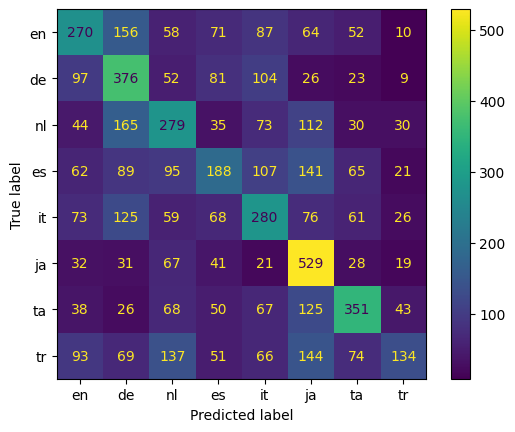

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(xticks_rotation='horizontal')
plt.savefig(f'plots/models/{name}.png')

In [15]:
import numpy as np
import seaborn as sns

heatmap_data = torch.zeros((num_classes, num_classes))

for i, label in enumerate(y_true):
    heatmap_data[label] += y_probs[i]

for i, row in enumerate(heatmap_data):
    heatmap_data[i] = heatmap_data[i] / sum(row)

# Normalize
counts = counts.masked_fill(counts == 0, 1.0)

# Normalize by number of samples per true class
avg_probs = heatmap_data 

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(avg_probs.numpy(), annot=True, fmt=".2f", cmap="magma",
            xticklabels=encoder.classes_,  # adjust as needed
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Average Predicted Probabilities for True Labels")
plt.tight_layout()

plt.savefig(f'plots/models/{name}_prob.png')



NameError: name 'counts' is not defined